In [1]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 4070 Laptop GPU
Using device: cuda


## 1 - Import Libraries

In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
# This allows normalization for the specgrams which allows for clearer visualizations
from matplotlib.colors import Normalize
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## 2- Load Dataset

for RAVDESS dataset 
(change ravdess_path based on the device you're using)

In [3]:
# Adjust this to where you placed the RAVDESS dataset
ravdess_path = r"C:\Users\Ezeniel Cuenca\Downloads\ravdess-20250824T034238Z-1-001\ravdess\audio_speech_actors_01-24"

# Put the ravdess directory in a list
ravdess = os.listdir(ravdess_path)

# Make a list for emotion labels and a list for path to audio files
emotions = []
paths = []
# Loop through all the audio file directories
for dir in ravdess:
    for file in os.listdir(os.path.join(ravdess_path, dir)):
        parts = file.split('-')
        if len(parts) < 3:
            continue  # skip files that don't match expected pattern
        emotion = parts[2]
        if emotion == '01':
            emotion = 'neutral'
        elif emotion == '02':
            emotion = 'calm'
        elif emotion == '03':
            emotion = 'happiness'
        elif emotion == '04':
            emotion = 'sadness'
        elif emotion == '05':
            emotion = 'anger'
        elif emotion == '06':
            emotion = 'fear'
        elif emotion == '07':
            emotion = 'disgust'
        elif emotion == '08':
            emotion = 'surprise'
        else:
            emotion = 'Unknown'
        path = os.path.join(ravdess_path, dir, file)
        emotions.append(emotion)
        paths.append(path)
# Create a dataframe from the lists
ravdess_df = pd.DataFrame(emotions, columns=['Emotion'])
ravdess_df['Path'] = paths
# Inspect the dataframe
ravdess_df.head()

,Emotion,Path
0,neutral,C:\Users\Ezeniel Cuenca\Downloads\ravdess-2025...
1,neutral,C:\Users\Ezeniel Cuenca\Downloads\ravdess-2025...
2,neutral,C:\Users\Ezeniel Cuenca\Downloads\ravdess-2025...
3,neutral,C:\Users\Ezeniel Cuenca\Downloads\ravdess-2025...
4,calm,C:\Users\Ezeniel Cuenca\Downloads\ravdess-2025...


# 3- Data Exploration, Preparation, and Visualization

C:\Users\Ezeniel Cuenca\AppData\Local\Temp\ipykernel_18456\2906042178.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ravdess_df, x = ravdess_df['Emotion'], palette='magma')


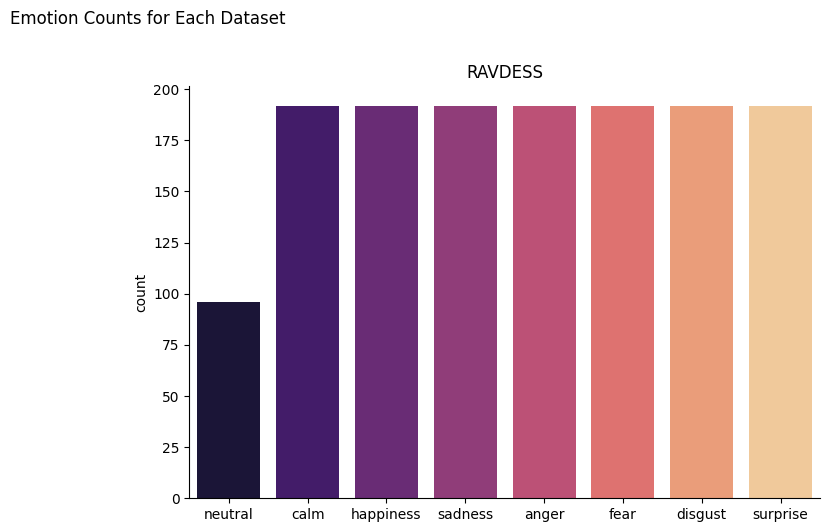

In [4]:
# Plot the value counts for each emotion in each dataset
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 2)
sns.countplot(ravdess_df, x = ravdess_df['Emotion'], palette='magma')
plt.title('RAVDESS')
plt.xlabel('')
plt.suptitle('Emotion Counts for Each Dataset')
# Adjust the layout so there are no overlapping titles
plt.tight_layout(pad=2)
# Remove the spines
sns.despine()
plt.show()

In [5]:
print('\nRAVDESS Emotion Counts:')
print(ravdess_df['Emotion'].value_counts())


RAVDESS Emotion Counts:
Emotion
calm         192
happiness    192
sadness      192
anger        192
disgust      192
fear         192
surprise     192
neutral       96
Name: count, dtype: int64


In [6]:
# Create a dataframe that contains all the emotion labels and paths from all the datasets
df = pd.concat([ravdess_df], axis=0)
# Reset the index
df = df.reset_index(drop=True)
# Inspect the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Emotion  1440 non-null   object
 1   Path     1440 non-null   object
dtypes: object(2)
memory usage: 22.6+ KB


C:\Users\Ezeniel Cuenca\AppData\Local\Temp\ipykernel_18456\352021329.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = df.groupby('Emotion', group_keys=False).apply(lambda x: x.sample(1))


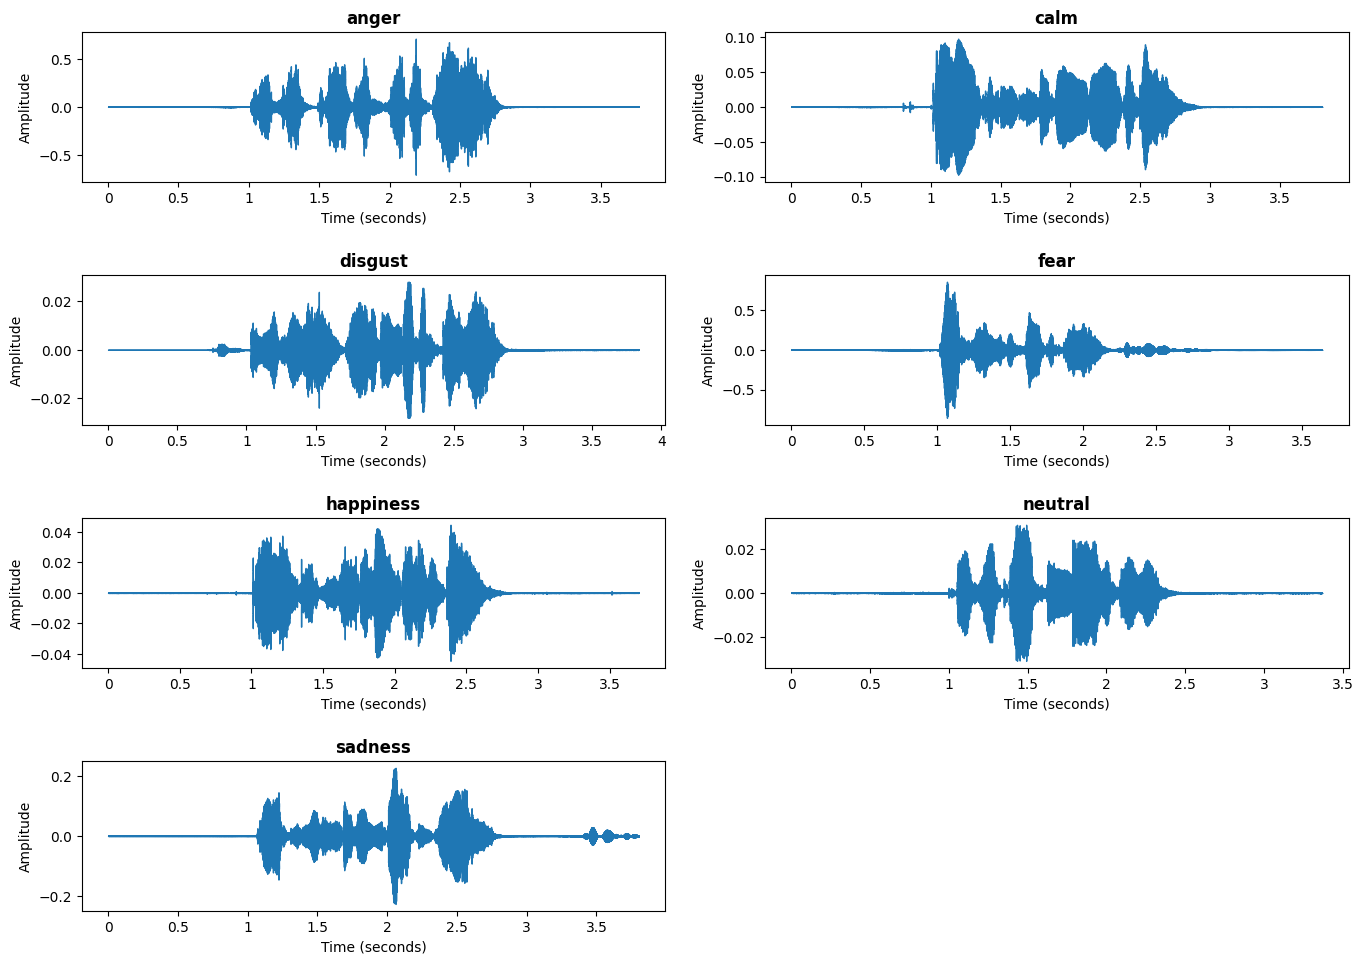

In [7]:
# Get a sample from each emotion type
sample = df.groupby('Emotion', group_keys=False).apply(lambda x: x.sample(1))
# extract the path from the sample
sample_paths = sample['Path'].tolist()
# Create a waveform plot for a sample of each emotion
plt.figure(figsize=(14, 10))
for i in range(7):
    plt.subplot(4, 2, i+1)
    # Load the audio file and set the sampling rate to 44100
    data, sr = librosa.load(sample_paths[i], sr = 44100)
    # Plot the waveform
    librosa.display.waveshow(data, sr=sr)
    # Add a title and make it bold
    plt.title(sample['Emotion'].values[i], fontweight='bold')
    # Add labels to the x and y axes
    plt.ylabel('Amplitude')
    plt.xlabel('Time (seconds)')
# Adjust the layout so there are no overlapping titles
plt.tight_layout(pad=2)

## 3 - Converting Mel Spectogtam to Log-Mel Spectogram

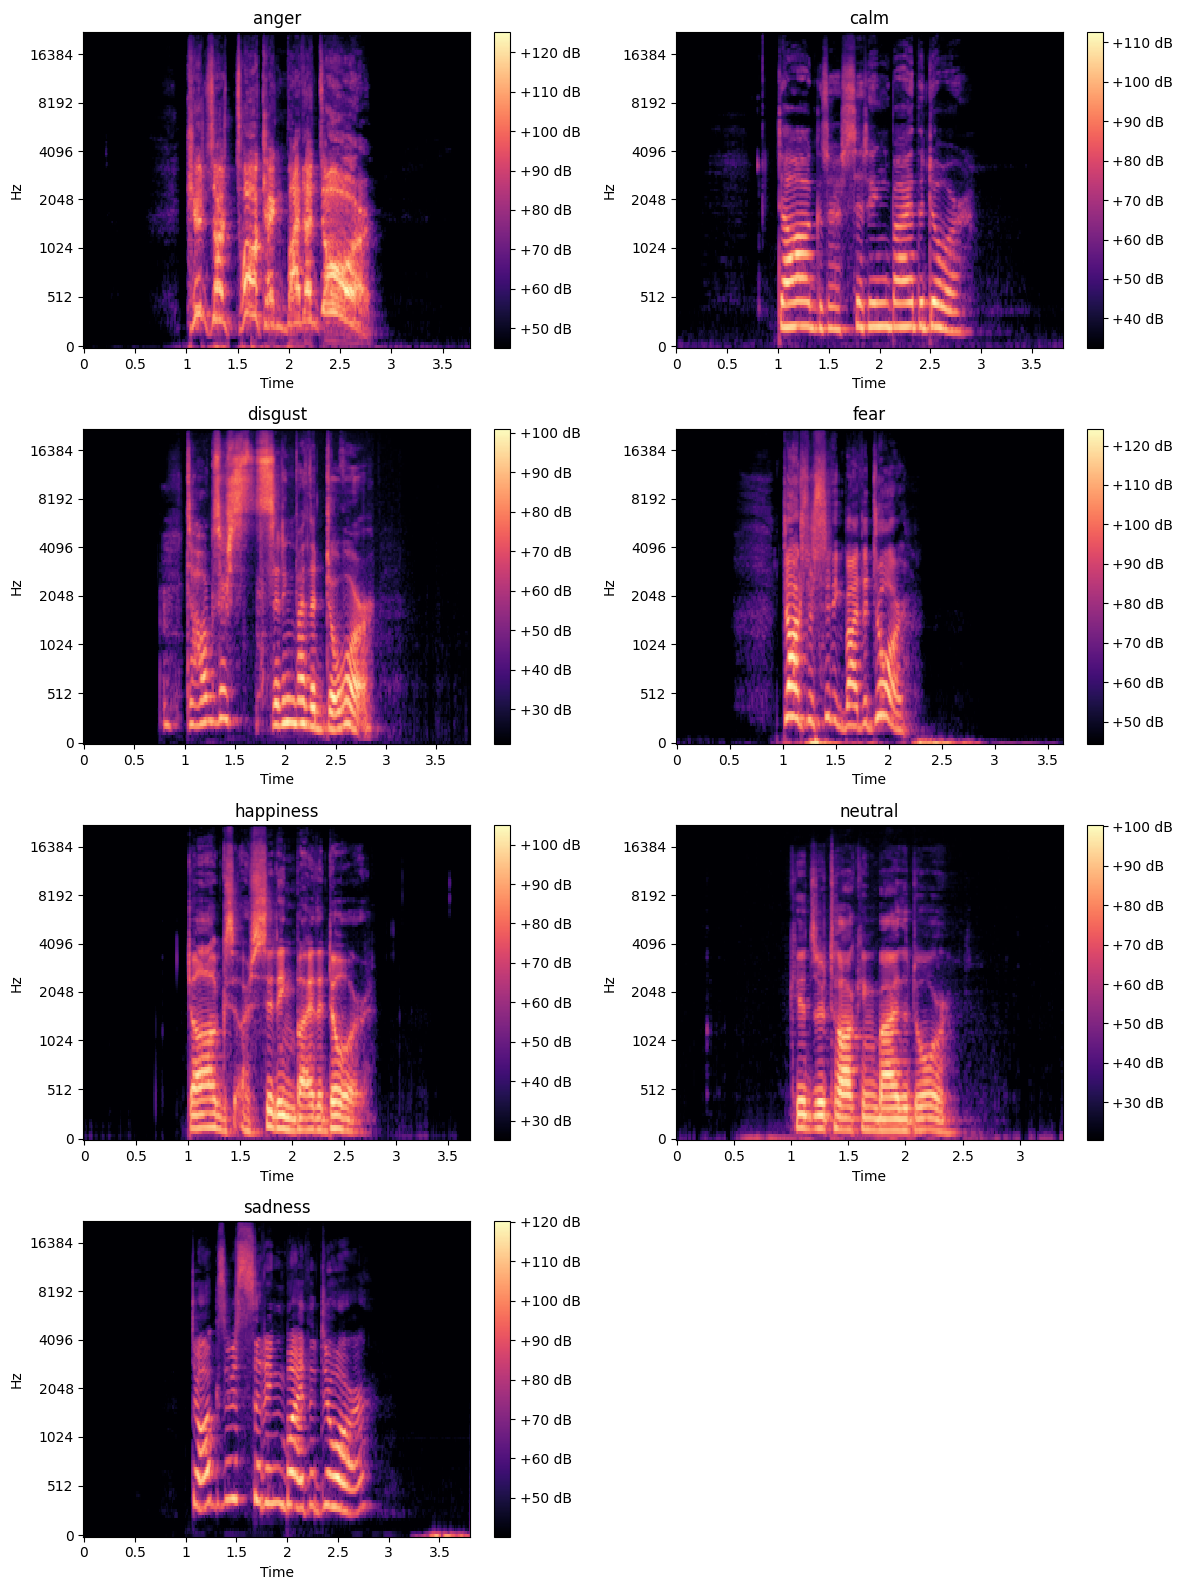

In [8]:
# Create a spectrogram plot for each emotion
plt.figure(figsize=(12, 16))
for i in range(7):
    plt.subplot(4, 2, i+1)
    # Load the audio file, we chose sr = 44100 to standardize the sampling rate
    signal, sr = librosa.load(sample_paths[i], sr=44100)
    # Make the logarithmically scaled mel spectrogram
    signal = librosa.feature.melspectrogram(y = signal, sr=sr)
    # Convert the spectrogram from amplitude squared to decibels
    # as amplitude does not give us much information
    signal = librosa.power_to_db(signal, ref=np.min)
    # Plot the spectrogram
    librosa.display.specshow(signal, sr=sr, x_axis='time', y_axis='mel')
    plt.title(sample['Emotion'].values[i])
    # Plot a color bar to show the intensity scale from 0 Decibels to the max
    plt.colorbar(format='%+2.0f dB')
plt.tight_layout()


## 4- Data Preprocessing

We will be using the librosa library to extract the Mel Spectrograms from the audio files. We will also be using the sklearn library to split the data into training and testing sets.

In [9]:
# Encode the emotion labels into numbers
encoder = LabelEncoder()
df['Emotion'] = encoder.fit_transform(df['Emotion'])
# Make sure the encoding worked
df['Emotion'].value_counts()

Emotion
1    192
4    192
6    192
0    192
2    192
3    192
7    192
5     96
Name: count, dtype: int64

In [10]:
# Create a function that takes an audio file path and returns the mel spectrogram
# as an image, and converts the image into a numpy array

def process_audio(path):
    """Process audio with paper's exact specifications"""
    # Load audio with paper's sampling rate
    audio, sr = librosa.load(path, sr=16000, duration=3)
    
    # Ensure consistent length (3 seconds)
    target_length = 3 * 16000
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)), 'constant')
    else:
        audio = audio[:target_length]
    
    # Extract mel spectrogram with exact dimensions
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_mels=128,
        n_fft=512,
        hop_length=312,  # Adjusted to get 259 time steps
        power=2.0
    )
    
    # Convert to log mel spectrogram
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Ensure exact shape of 128x259
    if mel_db.shape[1] != 259:
        mel_db = librosa.util.fix_length(mel_db, size=259, axis=1)
    
    # Normalize
    mel_db = (mel_db - np.mean(mel_db)) / np.std(mel_db)
    
    return mel_db




# Modify the process_audio function to ensure 259 time steps
# def process_audio(path):
#     '''
#     Load the audio file, convert the audio file into a mel spectrogram,
#     return the mel spectrogram as an image with shape (128, 259)
#     '''
#     audio, sr = librosa.load(path, sr=44100, duration=3, mono=True)  # Adjust duration to get 259 time steps
#     if len(audio) < 3 * sr:
#         audio = np.pad(audio, pad_width=(0, 3 * sr - len(audio)), mode='constant')
    
#     # Convert to mel spectrogram with specific size
#     signal = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, n_fft=2048, hop_length=512)
#     signal = librosa.power_to_db(signal, ref=np.min)
    
#     # Ensure exact shape of 128 x 259
#     if signal.shape[1] > 259:
#         signal = signal[:, :259]
#     elif signal.shape[1] < 259:
#         pad_width = 259 - signal.shape[1]
#         signal = np.pad(signal, ((0,0), (0,pad_width)), mode='constant')
    
#     return signal

# def process_audio(path):
#     '''
#     Load the audio file, convert the audio file into a mel spectrogram,
#     return the mel spectrogram as an image, and convert the image into a numpy array
#     '''
#     # Load the audio file and set the sampling rate to 44100
#     audio, sr = librosa.load(path, sr=44100, duration=4, mono=True)
#     # pad the audio files that are less than 4 seconds with zeros at the end
#     if len(audio) < 4 * sr:
#         audio = np.pad(audio, pad_width=(0, 4 * sr - len(audio)), mode='constant')
#     # Convert the audio file into a mel spectrogram
#     signal = librosa.feature.melspectrogram(y = audio, sr=sr, n_mels=128)
#     # Convert the spectrogram from amplitude squared to decibels
#     # as amplitude does not give us much information
#     signal = librosa.power_to_db(signal, ref=np.min)    # Convert the image into a numpy array
#     image = np.array(signal)
#     # Return the image
#     return image


Numpy array shape: (128, 259)


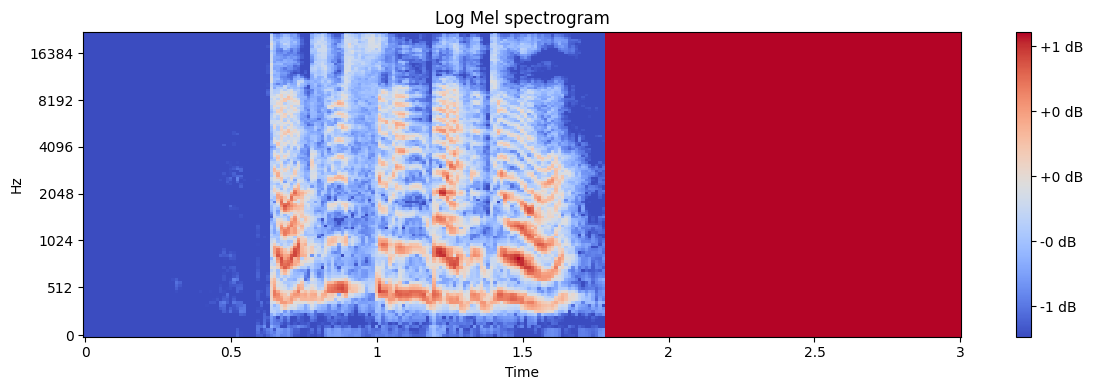

In [11]:
# Test the function on the sample audio file
image = process_audio(sample_paths[6])
# Print the shape of the numpy array
print('Numpy array shape:', image.shape)
# Plot the image
plt.figure(figsize=(12, 4))
librosa.display.specshow(image, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log Mel spectrogram')
plt.tight_layout()


In [12]:
# Divide the data into features and labels
X_mel = [process_audio(path) for path in df['Path']]
y_mel = df['Emotion']

In [13]:
# Check the length of the feature and label lists
print('Number of images:', len(X_mel))
print('Number of labels:', len(y_mel))

Number of images: 1440
Number of labels: 1440


Label: 5


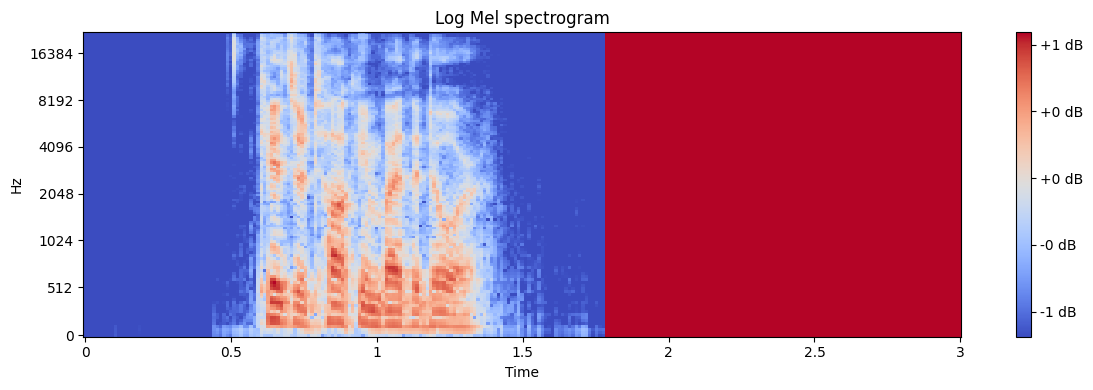

In [14]:
# Plot the first image and its corresponding label
plt.figure(figsize=(12, 4))
librosa.display.specshow(X_mel[0], sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log Mel spectrogram')
plt.tight_layout()
print('Label:', y_mel.iloc[0])

In [15]:
# Divide the data into training and testing sets, with a 80:20 split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_mel, y_mel,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    shuffle=True)

In [16]:
# Check the length of the training and testing sets
print('Number of training images:', len(X_train_1))
print('Number of testing images:', len(X_test_1))
print('Number of training labels:', len(y_train_1))
print('Number of testing labels:', len(y_test_1))

Number of training images: 1152
Number of testing images: 288
Number of training labels: 1152
Number of testing labels: 288


In [17]:
# Convert the lists into numpy arrays
X_train_1 = np.array(X_train_1)
X_test_1 = np.array(X_test_1)
y_train_1 = np.array(y_train_1)
y_test_1 = np.array(y_test_1)
# Check the shape of the arrays
print('X_train shape:', X_train_1.shape)
print('X_test shape:', X_test_1.shape)
print('y_train shape:', y_train_1.shape)
print('y_test shape:', y_test_1.shape)

X_train shape: (1152, 128, 259)
X_test shape: (288, 128, 259)
y_train shape: (1152,)
y_test shape: (288,)


In [18]:
from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train_1, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_1, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_1, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_1, dtype=torch.long)

batch_size = 16

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

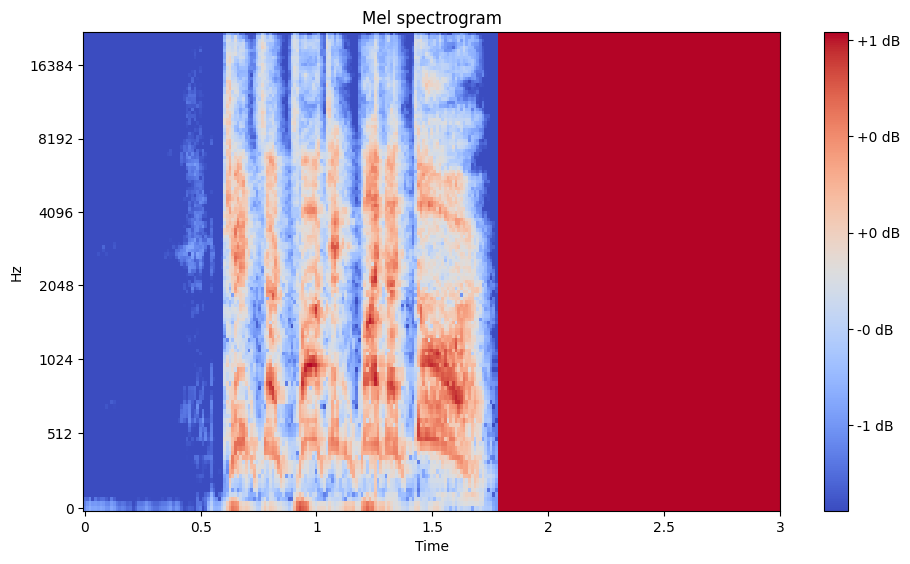

In [19]:
# plot the first image in the training set as a mel spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(X_train_1[0].reshape(128, 259), sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout(pad=2)

In [20]:
# Standardize the data by subtracting the mean and dividing by the standard deviation
mean = np.mean(X_train_1)
std = np.std(X_train_1)
X_train_1 = (X_train_1 - mean) / std
X_test_1 = (X_test_1 - mean) / std

In [21]:
# Check the mean and standard deviation
print('Mean:', mean)
print('Standard deviation:', std)
# Check if the data is standardized
print('Mean of standardized data:', np.mean(X_train_1))
print('Standard deviation of standardized data:', np.std(X_train_1))

Mean: 2.3972266e-10
Standard deviation: 0.9999993
Mean of standardized data: 4.2990265e-09
Standard deviation of standardized data: 1.0000001
Standard deviation of standardized data: 1.0000001


In [22]:
# Reshape the data into 4D arrays so that it can be input into the 2D CNN
X_train_1 = X_train_1.reshape(X_train_1.shape[0], 128, 259, 1)
X_test_1 = X_test_1.reshape(X_test_1.shape[0], 128, 259, 1)
# Check the shape of the arrays
print('X_train shape:', X_train_1.shape)
print('X_test shape:', X_test_1.shape)

X_train shape: (1152, 128, 259, 1)
X_test shape: (288, 128, 259, 1)


Next, we make a Dataset object from the data. This will allow us to make batches, and prefetch the data, which means that the data will be loaded to the GPU while the model is training on the previous batch. This will make the training process faster.

In [23]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train_1, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_1, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_1, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_1, dtype=torch.long)


# Dataset and DataLoader (equivalent to tf.data.Dataset)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
from torch.utils.data import TensorDataset, DataLoader

# Define batch size
batch_size = 16

# First ensure the input data is properly shaped and on the right device
X_train_tensor = torch.tensor(X_train_1, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_1, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_1, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_1, dtype=torch.long)

# Create dataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders with shuffling and pinned memory for faster GPU transfer
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=0  # Increase if using CPU, keep 0 for notebooks
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=0
)



## 5- Modeling

### 5.1- Log Mel Spectrogram CNN Model
We will treat the mel spectrograms as images and use a CNN to classify them. We will use the Adam optimizer and the sparse categorical cross entropy loss function.

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MelCNN(nn.Module):
    def __init__(self, num_classes=8):  # 8 emotions in RAVDESS
        super(MelCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # Fourth convolutional block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Dropout and final dense layer
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, num_classes)
        
    def forward(self, x):
        # First block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        # Second block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # Third block
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        # Fourth block
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        
        # Global average pooling
        x = self.global_pool(x)
        
        # Flatten and apply dropout
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        
        # Final dense layer
        x = self.fc(x)
        return x

In [26]:
# from torchviz import make_dot
# import torch

# # Create a sample input tensor with the correct shape
# sample_input = torch.randn(1, 1, 128, 345).to(device)  # Batch size 1, 1 channel, height 128, width 345



# # Pass it through the model
# output = model(sample_input)

# # Create and save the model visualization
# dot = make_dot(output, params=dict(model.named_parameters()))
# dot.render("model_architecture", format="png")

# # Display the image in the notebook
# from IPython.display import Image
# Image(filename='model_architecture.png')

In [27]:
from tqdm.notebook import tqdm
import time

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Create progress bar for training
    pbar = tqdm(train_loader, desc='Training', leave=False)
    
    for inputs, targets in pbar:
        # Move data to device
        inputs = inputs.permute(0, 3, 1, 2)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        current_loss = running_loss / (pbar.n + 1)
        current_acc = 100. * correct / total
        pbar.set_postfix({
            'loss': f'{current_loss:.4f}',
            'acc': f'{current_acc:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Create progress bar for validation
    pbar = tqdm(test_loader, desc='Validation', leave=False)
    
    with torch.no_grad():
        for inputs, targets in pbar:
            inputs = inputs.permute(0, 3, 1, 2)
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            current_loss = running_loss / (pbar.n + 1)
            current_acc = 100. * correct / total
            pbar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'acc': f'{current_acc:.2f}%'
            })
    
    val_loss = running_loss / len(test_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

In [28]:
class CRNN(nn.Module):
    def __init__(self, num_classes=8):
        super(CRNN, self).__init__()
        
        # mLFLB1: Conv(9x9) + Pool(2x2)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # mLFLB2: Conv(7x7) + Pool(4x4)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4)
        )
        
        # mLFLB3: Conv(5x5) + Pool(4x4)
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4)
        )
        
        # mLFLB4: Conv(3x3) + Pool(4x4)
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4)
        )
        
        # BiLSTM
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.5
        )
        
        # Dense + Softmax
        self.fc = nn.Linear(256, num_classes)  # 256 because bidirectional (128*2)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # CNN feature extraction
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        # Reshape for LSTM
        batch_size = x.size(0)
        seq_len = x.size(2) * x.size(3)
        x = x.permute(0, 2, 3, 1)
        x = x.reshape(batch_size, seq_len, -1)
        
        # BiLSTM
        x, _ = self.lstm(x)
        
        # Global average pooling
        x = torch.mean(x, dim=1)
        
        # Classification
        x = self.fc(x)
        x = self.softmax(x)
        
        return x


In [33]:
#Set device - CRNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize model
model = CRNN(num_classes=8).to(device)

# Loss function with label smoothing
criterion = nn.CrossEntropyLoss()

# Optimizer with weight decay
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001,
    weight_decay=0
)

# Training loop
num_epochs = 100
best_val_acc = 0.0  # Track best validation accuracy

# Training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# Best model checkpoint path
checkpoint_path = 'best_crnn_model.pth'

for epoch in range(num_epochs):
    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validation phase
    val_loss, val_acc = validate(model, test_loader, criterion, device)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Save best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # Save model checkpoint with all necessary information
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, checkpoint_path)
        print(f'New best model saved with validation accuracy: {val_acc:.2f}%')

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}]:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'Best Val Acc: {best_val_acc:.2f}%')
    print('-' * 60)

# Load best model
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\nLoaded best model from epoch {checkpoint['epoch']+1} with validation accuracy: {checkpoint['val_acc']:.2f}%")

Using device: cuda


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

New best model saved with validation accuracy: 23.96%
Epoch [1/100]:
Train Loss: 2.0755, Train Acc: 19.36%
Val Loss: 2.0712, Val Acc: 23.96%
Best Val Acc: 23.96%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

New best model saved with validation accuracy: 25.35%
Epoch [2/100]:
Train Loss: 2.0489, Train Acc: 25.43%
Val Loss: 2.0184, Val Acc: 25.35%
Best Val Acc: 25.35%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

New best model saved with validation accuracy: 37.50%
Epoch [3/100]:
Train Loss: 1.9810, Train Acc: 31.42%
Val Loss: 1.9320, Val Acc: 37.50%
Best Val Acc: 37.50%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [4/100]:
Train Loss: 1.9024, Train Acc: 39.50%
Val Loss: 1.9621, Val Acc: 27.78%
Best Val Acc: 37.50%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [5/100]:
Train Loss: 1.8522, Train Acc: 43.32%
Val Loss: 1.9232, Val Acc: 34.72%
Best Val Acc: 37.50%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

New best model saved with validation accuracy: 43.40%
Epoch [6/100]:
Train Loss: 1.7951, Train Acc: 48.00%
Val Loss: 1.8368, Val Acc: 43.40%
Best Val Acc: 43.40%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [7/100]:
Train Loss: 1.7591, Train Acc: 52.95%
Val Loss: 1.9268, Val Acc: 30.56%
Best Val Acc: 43.40%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

New best model saved with validation accuracy: 51.04%
Epoch [8/100]:
Train Loss: 1.7337, Train Acc: 55.73%
Val Loss: 1.7670, Val Acc: 51.04%
Best Val Acc: 51.04%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [9/100]:
Train Loss: 1.6833, Train Acc: 61.63%
Val Loss: 1.8951, Val Acc: 37.50%
Best Val Acc: 51.04%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [10/100]:
Train Loss: 1.6615, Train Acc: 63.19%
Val Loss: 1.8408, Val Acc: 43.06%
Best Val Acc: 51.04%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [11/100]:
Train Loss: 1.6415, Train Acc: 64.84%
Val Loss: 1.8973, Val Acc: 37.15%
Best Val Acc: 51.04%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [12/100]:
Train Loss: 1.6220, Train Acc: 66.93%
Val Loss: 1.7918, Val Acc: 46.18%
Best Val Acc: 51.04%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [13/100]:
Train Loss: 1.5959, Train Acc: 70.05%
Val Loss: 1.8319, Val Acc: 41.67%
Best Val Acc: 51.04%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [14/100]:
Train Loss: 1.5903, Train Acc: 70.05%
Val Loss: 1.7829, Val Acc: 49.31%
Best Val Acc: 51.04%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

New best model saved with validation accuracy: 52.43%
Epoch [15/100]:
Train Loss: 1.5763, Train Acc: 71.44%
Val Loss: 1.7534, Val Acc: 52.43%
Best Val Acc: 52.43%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

New best model saved with validation accuracy: 54.86%
Epoch [16/100]:
Train Loss: 1.5446, Train Acc: 74.57%
Val Loss: 1.7321, Val Acc: 54.86%
Best Val Acc: 54.86%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

New best model saved with validation accuracy: 56.60%
Epoch [17/100]:
Train Loss: 1.5237, Train Acc: 76.13%
Val Loss: 1.6983, Val Acc: 56.60%
Best Val Acc: 56.60%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

New best model saved with validation accuracy: 62.15%
Epoch [18/100]:
Train Loss: 1.5059, Train Acc: 77.34%
Val Loss: 1.6601, Val Acc: 62.15%
Best Val Acc: 62.15%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [19/100]:
Train Loss: 1.4865, Train Acc: 80.90%
Val Loss: 1.6916, Val Acc: 59.38%
Best Val Acc: 62.15%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [20/100]:
Train Loss: 1.4653, Train Acc: 83.51%
Val Loss: 1.7202, Val Acc: 55.56%
Best Val Acc: 62.15%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [21/100]:
Train Loss: 1.4422, Train Acc: 85.24%
Val Loss: 1.6789, Val Acc: 60.42%
Best Val Acc: 62.15%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

New best model saved with validation accuracy: 64.24%
Epoch [22/100]:
Train Loss: 1.4209, Train Acc: 87.93%
Val Loss: 1.6365, Val Acc: 64.24%
Best Val Acc: 64.24%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [23/100]:
Train Loss: 1.4268, Train Acc: 87.41%
Val Loss: 1.6842, Val Acc: 59.38%
Best Val Acc: 64.24%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [24/100]:
Train Loss: 1.3971, Train Acc: 89.67%
Val Loss: 1.6874, Val Acc: 58.68%
Best Val Acc: 64.24%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [25/100]:
Train Loss: 1.4013, Train Acc: 89.24%
Val Loss: 1.7298, Val Acc: 52.08%
Best Val Acc: 64.24%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [26/100]:
Train Loss: 1.3950, Train Acc: 89.50%
Val Loss: 1.8093, Val Acc: 44.44%
Best Val Acc: 64.24%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

New best model saved with validation accuracy: 67.36%
Epoch [27/100]:
Train Loss: 1.3853, Train Acc: 89.93%
Val Loss: 1.6189, Val Acc: 67.36%
Best Val Acc: 67.36%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [28/100]:
Train Loss: 1.3756, Train Acc: 90.80%
Val Loss: 1.7751, Val Acc: 47.57%
Best Val Acc: 67.36%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [29/100]:
Train Loss: 1.3822, Train Acc: 90.28%
Val Loss: 1.6060, Val Acc: 67.01%
Best Val Acc: 67.36%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [30/100]:
Train Loss: 1.3733, Train Acc: 90.71%
Val Loss: 1.7752, Val Acc: 49.31%
Best Val Acc: 67.36%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [31/100]:
Train Loss: 1.3745, Train Acc: 90.62%
Val Loss: 1.7390, Val Acc: 53.82%
Best Val Acc: 67.36%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [32/100]:
Train Loss: 1.3726, Train Acc: 90.97%
Val Loss: 1.7173, Val Acc: 56.25%
Best Val Acc: 67.36%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [33/100]:
Train Loss: 1.3726, Train Acc: 90.80%
Val Loss: 1.6902, Val Acc: 59.03%
Best Val Acc: 67.36%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [34/100]:
Train Loss: 1.3700, Train Acc: 91.41%
Val Loss: 1.6265, Val Acc: 63.89%
Best Val Acc: 67.36%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [35/100]:
Train Loss: 1.3658, Train Acc: 91.32%
Val Loss: 1.6253, Val Acc: 65.62%
Best Val Acc: 67.36%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [36/100]:
Train Loss: 1.3576, Train Acc: 92.10%
Val Loss: 1.6576, Val Acc: 60.42%
Best Val Acc: 67.36%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [37/100]:
Train Loss: 1.3565, Train Acc: 92.27%
Val Loss: 1.6346, Val Acc: 63.54%
Best Val Acc: 67.36%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [38/100]:
Train Loss: 1.3530, Train Acc: 92.45%
Val Loss: 1.6596, Val Acc: 61.46%
Best Val Acc: 67.36%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [39/100]:
Train Loss: 1.3536, Train Acc: 92.45%
Val Loss: 1.6799, Val Acc: 58.33%
Best Val Acc: 67.36%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [40/100]:
Train Loss: 1.3520, Train Acc: 92.45%
Val Loss: 1.6196, Val Acc: 64.58%
Best Val Acc: 67.36%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [41/100]:
Train Loss: 1.3487, Train Acc: 92.71%
Val Loss: 1.6093, Val Acc: 66.32%
Best Val Acc: 67.36%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

New best model saved with validation accuracy: 69.44%
Epoch [42/100]:
Train Loss: 1.3476, Train Acc: 92.71%
Val Loss: 1.5903, Val Acc: 69.44%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [43/100]:
Train Loss: 1.3471, Train Acc: 92.71%
Val Loss: 1.5901, Val Acc: 68.75%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [44/100]:
Train Loss: 1.3465, Train Acc: 92.71%
Val Loss: 1.6017, Val Acc: 67.01%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [45/100]:
Train Loss: 1.3465, Train Acc: 92.71%
Val Loss: 1.6152, Val Acc: 65.28%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [46/100]:
Train Loss: 1.3457, Train Acc: 92.80%
Val Loss: 1.5872, Val Acc: 68.06%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [47/100]:
Train Loss: 1.3454, Train Acc: 92.80%
Val Loss: 1.5862, Val Acc: 68.75%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [48/100]:
Train Loss: 1.3488, Train Acc: 92.53%
Val Loss: 1.6144, Val Acc: 67.01%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [49/100]:
Train Loss: 1.3469, Train Acc: 92.71%
Val Loss: 1.6126, Val Acc: 65.28%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [50/100]:
Train Loss: 1.3456, Train Acc: 92.80%
Val Loss: 1.6103, Val Acc: 65.97%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [51/100]:
Train Loss: 1.3437, Train Acc: 93.06%
Val Loss: 1.6722, Val Acc: 60.42%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [52/100]:
Train Loss: 1.3507, Train Acc: 92.36%
Val Loss: 1.6191, Val Acc: 64.24%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [53/100]:
Train Loss: 1.3563, Train Acc: 92.19%
Val Loss: 1.6979, Val Acc: 57.99%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [54/100]:
Train Loss: 1.3670, Train Acc: 91.23%
Val Loss: 1.6212, Val Acc: 65.62%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [55/100]:
Train Loss: 1.3795, Train Acc: 90.45%
Val Loss: 1.7878, Val Acc: 47.22%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [56/100]:
Train Loss: 1.3760, Train Acc: 90.80%
Val Loss: 1.7697, Val Acc: 50.00%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [57/100]:
Train Loss: 1.3615, Train Acc: 91.93%
Val Loss: 1.6194, Val Acc: 65.97%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [58/100]:
Train Loss: 1.3589, Train Acc: 91.93%
Val Loss: 1.7296, Val Acc: 54.51%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [59/100]:
Train Loss: 1.3482, Train Acc: 92.80%
Val Loss: 1.6202, Val Acc: 65.28%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [60/100]:
Train Loss: 1.3513, Train Acc: 92.62%
Val Loss: 1.6406, Val Acc: 64.24%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [61/100]:
Train Loss: 1.3465, Train Acc: 92.97%
Val Loss: 1.6405, Val Acc: 61.81%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [62/100]:
Train Loss: 1.3448, Train Acc: 93.14%
Val Loss: 1.7100, Val Acc: 56.25%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [63/100]:
Train Loss: 1.3528, Train Acc: 92.45%
Val Loss: 1.7459, Val Acc: 52.43%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [64/100]:
Train Loss: 1.3479, Train Acc: 92.80%
Val Loss: 1.6268, Val Acc: 63.89%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [65/100]:
Train Loss: 1.3434, Train Acc: 93.06%
Val Loss: 1.6242, Val Acc: 64.24%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [66/100]:
Train Loss: 1.3435, Train Acc: 93.06%
Val Loss: 1.6278, Val Acc: 64.24%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [67/100]:
Train Loss: 1.3414, Train Acc: 93.23%
Val Loss: 1.5878, Val Acc: 68.75%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [68/100]:
Train Loss: 1.3402, Train Acc: 93.32%
Val Loss: 1.6191, Val Acc: 65.62%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [69/100]:
Train Loss: 1.3401, Train Acc: 93.32%
Val Loss: 1.5972, Val Acc: 66.32%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [70/100]:
Train Loss: 1.3397, Train Acc: 93.32%
Val Loss: 1.6453, Val Acc: 62.15%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [71/100]:
Train Loss: 1.3427, Train Acc: 93.06%
Val Loss: 1.6038, Val Acc: 66.67%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [72/100]:
Train Loss: 1.3391, Train Acc: 93.40%
Val Loss: 1.7775, Val Acc: 49.65%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [73/100]:
Train Loss: 1.3388, Train Acc: 94.44%
Val Loss: 1.6287, Val Acc: 65.28%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [74/100]:
Train Loss: 1.3253, Train Acc: 95.49%
Val Loss: 1.6310, Val Acc: 64.93%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [75/100]:
Train Loss: 1.3359, Train Acc: 95.05%
Val Loss: 1.7196, Val Acc: 55.90%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [76/100]:
Train Loss: 1.3327, Train Acc: 95.14%
Val Loss: 1.6781, Val Acc: 59.72%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [77/100]:
Train Loss: 1.3255, Train Acc: 95.75%
Val Loss: 1.7111, Val Acc: 55.21%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [78/100]:
Train Loss: 1.3359, Train Acc: 94.10%
Val Loss: 1.5979, Val Acc: 67.71%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [79/100]:
Train Loss: 1.3142, Train Acc: 96.18%
Val Loss: 1.7030, Val Acc: 56.25%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [80/100]:
Train Loss: 1.3050, Train Acc: 97.57%
Val Loss: 1.6148, Val Acc: 65.62%
Best Val Acc: 69.44%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

New best model saved with validation accuracy: 70.14%
Epoch [81/100]:
Train Loss: 1.2983, Train Acc: 98.09%
Val Loss: 1.5798, Val Acc: 70.14%
Best Val Acc: 70.14%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

New best model saved with validation accuracy: 73.26%
Epoch [82/100]:
Train Loss: 1.2996, Train Acc: 97.92%
Val Loss: 1.5422, Val Acc: 73.26%
Best Val Acc: 73.26%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [83/100]:
Train Loss: 1.2882, Train Acc: 98.96%
Val Loss: 1.5957, Val Acc: 67.36%
Best Val Acc: 73.26%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [84/100]:
Train Loss: 1.2864, Train Acc: 99.13%
Val Loss: 1.6108, Val Acc: 65.62%
Best Val Acc: 73.26%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [85/100]:
Train Loss: 1.2854, Train Acc: 99.31%
Val Loss: 1.6109, Val Acc: 65.62%
Best Val Acc: 73.26%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [86/100]:
Train Loss: 1.2883, Train Acc: 99.05%
Val Loss: 1.6682, Val Acc: 60.76%
Best Val Acc: 73.26%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [87/100]:
Train Loss: 1.2885, Train Acc: 98.87%
Val Loss: 1.5858, Val Acc: 68.06%
Best Val Acc: 73.26%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [88/100]:
Train Loss: 1.2903, Train Acc: 98.78%
Val Loss: 1.6431, Val Acc: 64.24%
Best Val Acc: 73.26%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [89/100]:
Train Loss: 1.2833, Train Acc: 99.31%
Val Loss: 1.6197, Val Acc: 64.24%
Best Val Acc: 73.26%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [90/100]:
Train Loss: 1.2834, Train Acc: 99.39%
Val Loss: 1.5924, Val Acc: 68.75%
Best Val Acc: 73.26%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [91/100]:
Train Loss: 1.2826, Train Acc: 99.22%
Val Loss: 1.6557, Val Acc: 62.15%
Best Val Acc: 73.26%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [92/100]:
Train Loss: 1.2820, Train Acc: 99.48%
Val Loss: 1.5757, Val Acc: 70.49%
Best Val Acc: 73.26%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [93/100]:
Train Loss: 1.2805, Train Acc: 99.48%
Val Loss: 1.5627, Val Acc: 70.83%
Best Val Acc: 73.26%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [94/100]:
Train Loss: 1.2822, Train Acc: 99.31%
Val Loss: 1.5596, Val Acc: 72.57%
Best Val Acc: 73.26%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [95/100]:
Train Loss: 1.2807, Train Acc: 99.48%
Val Loss: 1.6337, Val Acc: 63.89%
Best Val Acc: 73.26%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [96/100]:
Train Loss: 1.2862, Train Acc: 98.78%
Val Loss: 1.8037, Val Acc: 46.53%
Best Val Acc: 73.26%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [97/100]:
Train Loss: 1.2963, Train Acc: 98.35%
Val Loss: 1.9480, Val Acc: 32.29%
Best Val Acc: 73.26%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [98/100]:
Train Loss: 1.2948, Train Acc: 98.35%
Val Loss: 1.7052, Val Acc: 55.56%
Best Val Acc: 73.26%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [99/100]:
Train Loss: 1.3078, Train Acc: 96.96%
Val Loss: 1.7187, Val Acc: 54.86%
Best Val Acc: 73.26%
------------------------------------------------------------


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch [100/100]:
Train Loss: 1.3055, Train Acc: 97.14%
Val Loss: 1.7244, Val Acc: 53.82%
Best Val Acc: 73.26%
------------------------------------------------------------

Loaded best model from epoch 82 with validation accuracy: 73.26%


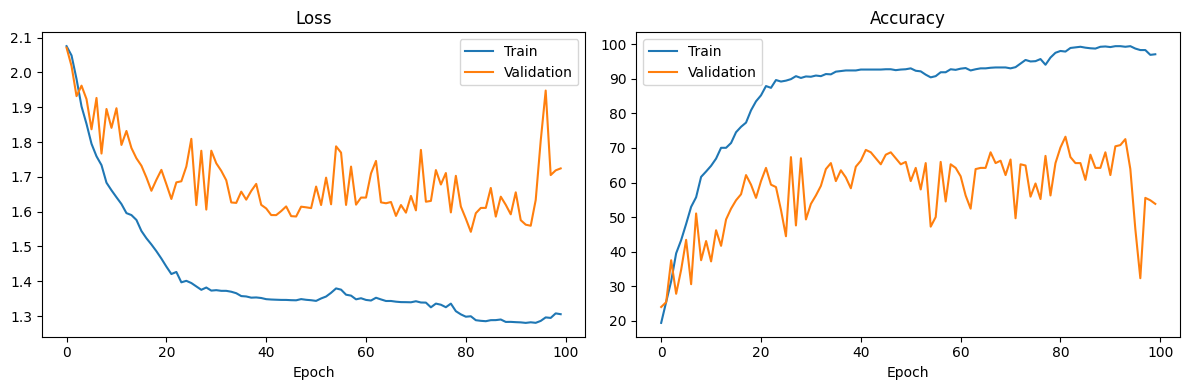

In [34]:
# Plot training historyasdn
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
# Get model predictions on test set
def get_predictions(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.permute(0, 3, 1, 2)
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.numpy())
            
    return np.array(all_predictions), np.array(all_targets)

# Get predictions
y_pred, y_true = get_predictions(model, test_loader, device)

# Print classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.classes_))



Classification Report:
              precision    recall  f1-score   support

       anger       0.75      0.79      0.77        34
        calm       0.86      0.86      0.86        44
     disgust       0.85      0.71      0.77        31
        fear       0.69      0.66      0.68        41
   happiness       0.66      0.70      0.68        33
     neutral       0.62      0.64      0.63        25
     sadness       0.57      0.66      0.61        38
    surprise       0.87      0.79      0.82        42

    accuracy                           0.73       288
   macro avg       0.73      0.73      0.73       288
weighted avg       0.74      0.73      0.73       288



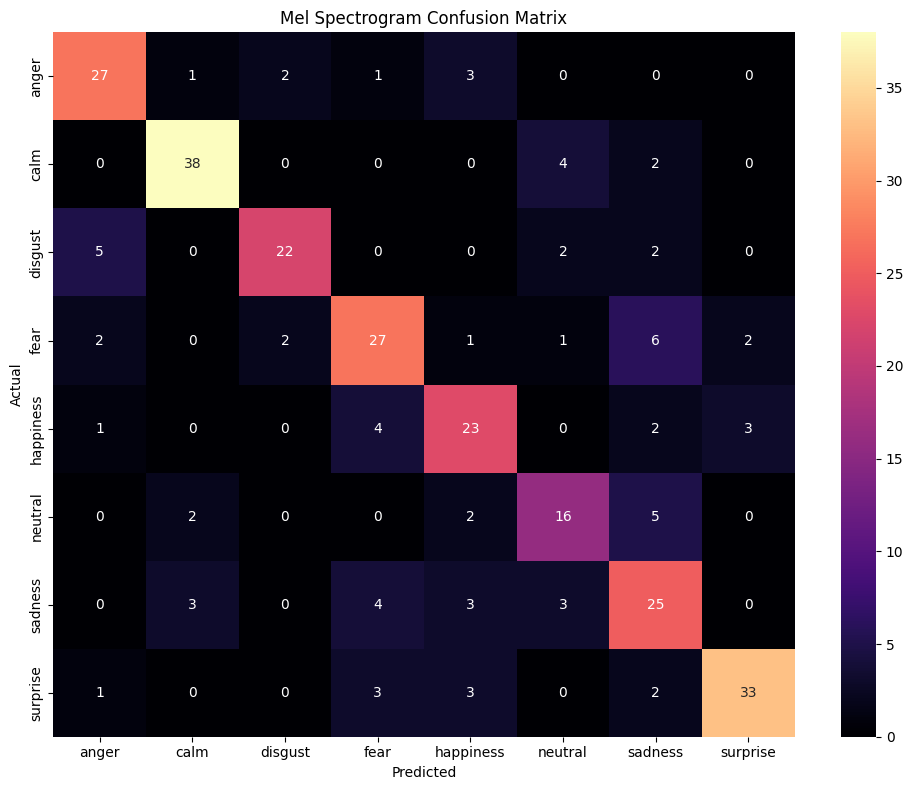


Per-class Accuracy:
anger: 79.41%
calm: 86.36%
disgust: 70.97%
fear: 65.85%
happiness: 69.70%
neutral: 64.00%
sadness: 65.79%
surprise: 78.57%


In [36]:
# Create and plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm_df = pd.DataFrame(cm, index=encoder.classes_, columns=encoder.classes_)
sns.heatmap(cm_df, annot=True, fmt='d', cmap='magma')
plt.title('Mel Spectrogram Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Calculate and print per-class accuracy
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("\nPer-class Accuracy:")
for cls, acc in zip(encoder.classes_, class_accuracy):
    print(f"{cls}: {acc:.2%}")